In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#pth='alpha2/'
pth='../sklearn/data/alpha2/'

mf15 = np.load(pth + 'mfields_R15e3.npz')
mf9  = np.load(pth + 'mfields_R9e3.npz') 
mf5  = np.load(pth + 'mfields_R5e3.npz')
mf1  = np.load(pth + 'mfields_R1e3.npz') 
mf05 = np.load(pth + 'mfields_R5e2.npz')

In [3]:
def read_mf(fname='mfields.npz'):
    mf = np.load(fname)
    return mf['bxm'], mf['bym'], mf['jxm'], mf['jym'], mf['emfx'], mf['emfy']

def ave_t(arr,tone=1000,ttwo=2000,verbose=None):
    if verbose:
        print(f't1: {tone}, t2: {ttwo}')
    return np.mean(arr[tone:ttwo,:],axis=0)

def gen_df_tave(fname='mfields.npz',t1=1000,t2=2000,verbose=None):
    '''
    Generate a dataframe by averaging squared fields over t from t1 to t2
    '''

    if verbose:
        print(f"Generating time averaged dataframe with t1: {t1} and t2: {t2}")
  
    bxm,bym,jxm,jym,Exm,Eym = read_mf(fname=fname)
    
    return pd.DataFrame.from_dict({
        'Bx': ave_t(bxm,tone=t1,ttwo=t2),
        'By': ave_t(bym,tone=t1,ttwo=t2),
        'Jx': ave_t(jxm,tone=t1,ttwo=t2),
        'Jy': ave_t(jym,tone=t1,ttwo=t2),
        'Ex': -1. * ave_t(Exm,tone=t1,ttwo=t2), # changed signs
        'Ey': -1. * ave_t(Eym,tone=t1,ttwo=t2)  # Since PENCIL computes -VxB
        })

def scale_df(df):
    '''
    Call:   df_ss, scl = scale_df(df)
    Inv. Transform: dfn = scl.inverse_transform(df_ss)
    Check equality: np.allclose(df.to_numpy(),dfn.to_numpy())
    '''

    from sklearn.preprocessing import StandardScaler
    df_ss = df.copy()
    scl   = StandardScaler()
    df_ss = scl.fit_transform(df_ss)
    return pd.DataFrame(df_ss,columns=df.columns),scl

In [4]:
# LOAD data into dataframes
df15 = gen_df_tave(fname=pth + 'mfields_R15e3.npz',t1=1500,t2=-1)
df5  = gen_df_tave(fname=pth + 'mfields_R5e3.npz',t1=1000,t2=-1)
df1  = gen_df_tave(fname=pth + 'mfields_R1e3.npz',t1=1250,t2=2000)
df05 = gen_df_tave(fname=pth + 'mfields_R5e2.npz',t1=4000,t2=5000)

In [5]:
# SCALING - useful for correlations/plots
data_ss, _ = scale_df(df15)

Text(0.5, 0, 'z')

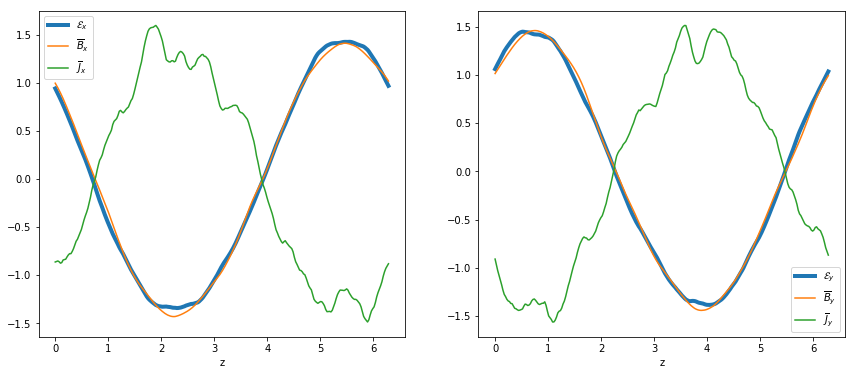

In [6]:
# Define the vertical coordinate: 0 to Lz = 2\pi
z_ax = np.linspace(0,2*np.pi,256)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
plt.subplots_adjust(left=0.2, hspace=0.25)

ax1.plot(z_ax,data_ss['Ex'],lw=4,label=r'$\mathcal{E}_x$')
ax1.plot(z_ax,data_ss['Bx'],label=r'$\overline{B}_x$')
ax1.plot(z_ax,data_ss['Jx'],label=r'$\overline{J}_x$')
ax1.legend()
ax1.set_xlabel('z')

ax2.plot(z_ax,data_ss['Ey'],lw=4,label=r'$\mathcal{E}_y$')
ax2.plot(z_ax,data_ss['By'],label=r'$\overline{B}_y$')
ax2.plot(z_ax,data_ss['Jy'],label=r'$\overline{J}_y$')
ax2.legend()
ax2.set_xlabel('z')

#fig.savefig('vertprof.pdf', bbox_inches='tight')

## Correlation heatmap

In [7]:
# Borrows code from SEABORN documentation
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
def df_corr_plot(df,fname=None,t1=1000,t2=2000,scal=None,verbose=None,savfig=False,labs=None):
    if fname:
        print('Using file: ',fname)
        df = gen_df_tave(fname=fname,t1=t1,t2=t2,verbose=verbose)
    if scal:
        print('Scaling data before plotting correlations')
        df_ss, _ = scale_df(df)
        df       = df_ss.copy()

    corr_matrix = df.corr()

    sns.set(style="white")

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr_matrix, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr_matrix, annot=True, cbar=False, mask=mask, cmap=cmap, vmax=1.0, vmin=-1.0, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

    if labs is None:
        labs = [r'$\overline{B}_x$',r'$\overline{B}_y$',r'$\overline{J}_x$',r'$\overline{J}_y$',r'$\mathcal{E}_x$',r'$\mathcal{E}_y$']

    #ax.set_xticklabels(labels=df.columns,fontsize=16,rotation=45)
    #ax.set_yticklabels(labels=df.columns,fontsize=16,rotation=45)
    ax.set_xticklabels(labels=labs,fontsize=20,rotation=45)
    ax.set_yticklabels(labels=labs,fontsize=20,rotation=45)
    #ax.set_yticklabels(labels=labs[::-1],fontsize=16,rotation=45)

    if savfig:
        try:
            os.makedirs("correlation")
        except FileExistsError:
        # directory already exists
            pass
        savfile = 'correlation/corr.pdf'
        fig.savefig(savfile,bbox_inches='tight')

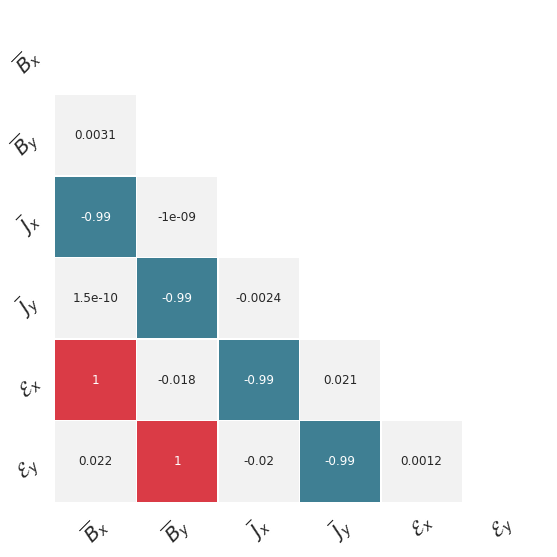

In [8]:
df_corr_plot(data_ss)